In [1]:
!pip install mplfinance
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.3 MB/s eta 0:00:00


In [2]:
import datetime as dt

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import yfinance as yf
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential

In [3]:
start_date = "2018-01-01"
end_date = dt.date.today()

aapl = yf.Ticker("AAPL")
data = aapl.history(start=start_date, end=end_date)

data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,40.030317,40.533754,39.818588,40.524342,102223600,0.0,0.0
2018-01-03 00:00:00-05:00,40.587864,41.063072,40.453773,40.517288,118071600,0.0,0.0
2018-01-04 00:00:00-05:00,40.590216,40.809001,40.482002,40.705490,89738400,0.0,0.0
2018-01-05 00:00:00-05:00,40.801943,41.255976,40.710195,41.168934,94640000,0.0,0.0
2018-01-08 00:00:00-05:00,41.016014,41.312429,40.917206,41.016014,82271200,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-19 00:00:00-05:00,226.979996,230.160004,226.660004,228.279999,36211800,0.0,0.0
2024-11-20 00:00:00-05:00,228.059998,229.929993,225.889999,229.000000,35169600,0.0,0.0
2024-11-21 00:00:00-05:00,228.880005,230.160004,225.710007,228.520004,42108300,0.0,0.0


In [4]:
data["MACD"] = (
    data["Close"].ewm(span=12, adjust=False).mean()
    - data["Close"].ewm(span=26, adjust=False).mean()
)
data["Signal_Line"] = data["MACD"].ewm(span=9, adjust=False).mean()
data["MACD_diff"] = data["MACD"] - data["Signal_Line"]

window_length = 14
delta = data["Close"].diff(1)
delta = delta[1:]
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
data["RSI"] = 100 - (
    100
    / (
        1
        + (up.rolling(window_length).mean() / down.abs().rolling(window_length).mean())
    )
)

# Calculate Simple Moving Averages (SMA)
data["SMA_5"] = data["Close"].rolling(window=5).mean()
data["SMA_10"] = data["Close"].rolling(window=10).mean()
data["SMA_20"] = data["Close"].rolling(window=20).mean()
data["SMA_50"] = data["Close"].rolling(window=50).mean()
data["SMA_100"] = data["Close"].rolling(window=100).mean()


data["Label"] = np.where(
    data["SMA_5"] > data["SMA_10"], 1, 0
)  # 1 for 'Up', 0 for 'Down'

# Convert relevant columns to numeric, coercing errors to NaN
data[["Open", "High", "Low", "Close", "Volume"]] = data[
    ["Open", "High", "Low", "Close", "Volume"]
].apply(pd.to_numeric, errors="coerce")

labels = data["Label"].dropna()

In [5]:
look_back = 30  # N days of K-line data as input

In [6]:
import io

# Prepare K-line data
k_line_data = data[["Open", "High", "Low", "Close", "Volume"]].dropna()


def create_cnn_dataset():
    X, y = [], []
    for i in tqdm(range(100, len(data) - look_back, int(look_back / 2))):
        _x = data.iloc[i : i + look_back]
        # Plot K-line chart
        buffer = io.BytesIO()
        mpf.plot(
            _x,
            type="candle",
            style="charles",
            volume=False,
            savefig=buffer,
            xrotation=0,
            ylabel="",
            xlabel="",
        )
        buffer.seek(0)
        img = plt.imread(buffer)
        img_cropped = img[70:470, 150:720] # Crop the image
        img_cropped = np.array(img_cropped)
        img_cropped = img_cropped[::2, ::2] # Downsample the image
        img_cropped = img_cropped[:, :, :3] # Remove alpha channel
        buffer.close()

        # Collect Price data
        price_data = _x[
            ["MACD_diff", "RSI", "SMA_20", "SMA_50", "SMA_100", "Close"]
        ].values
        scaled_price_data = StandardScaler().fit_transform(price_data)

        X.append({"image": img_cropped, "price": scaled_price_data})
        y.append(labels.iloc[i + look_back])
    return X, np.array(y)


# Create dataset for CNN
X, y = create_cnn_dataset()

  0%|          | 0/108 [00:00<?, ?it/s]

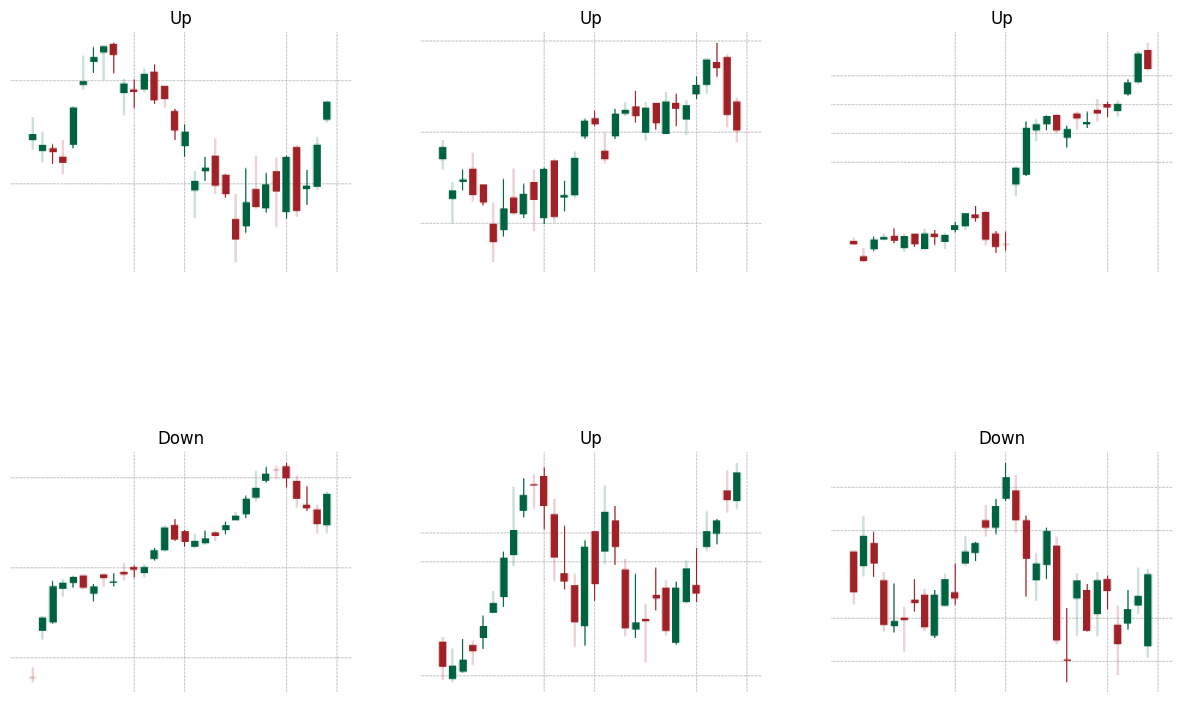

In [7]:
# plot some of the images
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    ax[i // 3, i % 3].imshow(X[i]["image"])
    ax[i // 3, i % 3].set_title("Up" if y[i] == 1 else "Down")
    ax[i // 3, i % 3].axis("off")
plt.show()

In [8]:
X_train_img = np.array([x["image"] for x in X])
X_train_price = np.array([x["price"] for x in X])

X_train_img.shape, X_train_price.shape

((108, 200, 285, 3), (108, 30, 6))

In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_img = np.array([x["image"] for x in X_train])
X_train_price = np.array([x["price"] for x in X_train])
X_test_img = np.array([x["image"] for x in X_test])
X_test_price = np.array([x["price"] for x in X_test])

X_train_img.shape, X_test_img.shape

((86, 200, 285, 3), (22, 200, 285, 3))

In [10]:
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    Flatten,
    Dropout,
    MaxPooling2D,
    concatenate,
)
from tensorflow.keras.models import Model

# Define the CNN model
input_cnn = Input(shape=(200, 285, 3))
x = Conv2D(32, (3, 3), activation="relu")(input_cnn)
x = MaxPooling2D((2, 1))(x)
x = Dropout(0.25)(x)
x = Conv2D(64, (2, 2), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
output_cnn = Dense(1, activation="sigmoid")(x)
cnn_model = Model(inputs=input_cnn, outputs=output_cnn)

# Define the NN model
input_nn = Input(shape=(30, 6))
y = Dense(64, activation="relu")(input_nn)
y = Dropout(0.25)(y)
y = Flatten()(y)
y = Dense(64, activation="relu")(y)
y = Dropout(0.5)(y)
output_nn = Dense(1, activation="sigmoid")(y)
nn_model = Model(inputs=input_nn, outputs=output_nn)

# Concatenate the two models
combined = concatenate([cnn_model.output, nn_model.output])
z = Dense(64, activation="relu")(combined)
z = Dropout(0.5)(z)
z = Dense(64, activation="relu")(z)
z = Dropout(0.5)(z)
output = Dense(1, activation="sigmoid")(z)
model = Model(inputs=[cnn_model.input, nn_model.input], outputs=output)

In [11]:
# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Add EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
model.fit(
    [X_train_img, X_train_price],
    y_train,
    batch_size=32,
    epochs=50,
    shuffle=True,
    validation_data=([X_test_img, X_test_price], y_test),
    callbacks=[early_stopping],
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5313 - loss: 0.6910 - val_accuracy: 0.6364 - val_loss: 0.6897
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.5077 - loss: 0.6948 - val_accuracy: 0.6364 - val_loss: 0.6881
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5855 - loss: 0.6910 - val_accuracy: 0.6364 - val_loss: 0.6857
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.4629 - loss: 0.6934 - val_accuracy: 0.6364 - val_loss: 0.6827
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5700 - loss: 0.6893 - val_accuracy: 0.6364 - val_loss: 0.6795
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5000 - loss: 0.6825 - val_accuracy: 0.6364 - val_loss: 0.6771
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.4046 - loss: 0.6998 - val_accuracy: 0.6364 - val_loss: 0.6751
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.4552 - loss: 0.6992 - val_accuracy: 0.6364 - val_loss: 0

In [12]:
# Make predictions
y_pred = model.predict([X_test_img, X_test_price])
y_pred_labels = (y_pred > 0.5).astype(int).reshape(-1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {test_accuracy:.2f}')

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
print('Confusion Matrix:')
print(conf_matrix)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
Test Accuracy: 0.91
Confusion Matrix:
[[ 7  1]
 [ 1 13]]


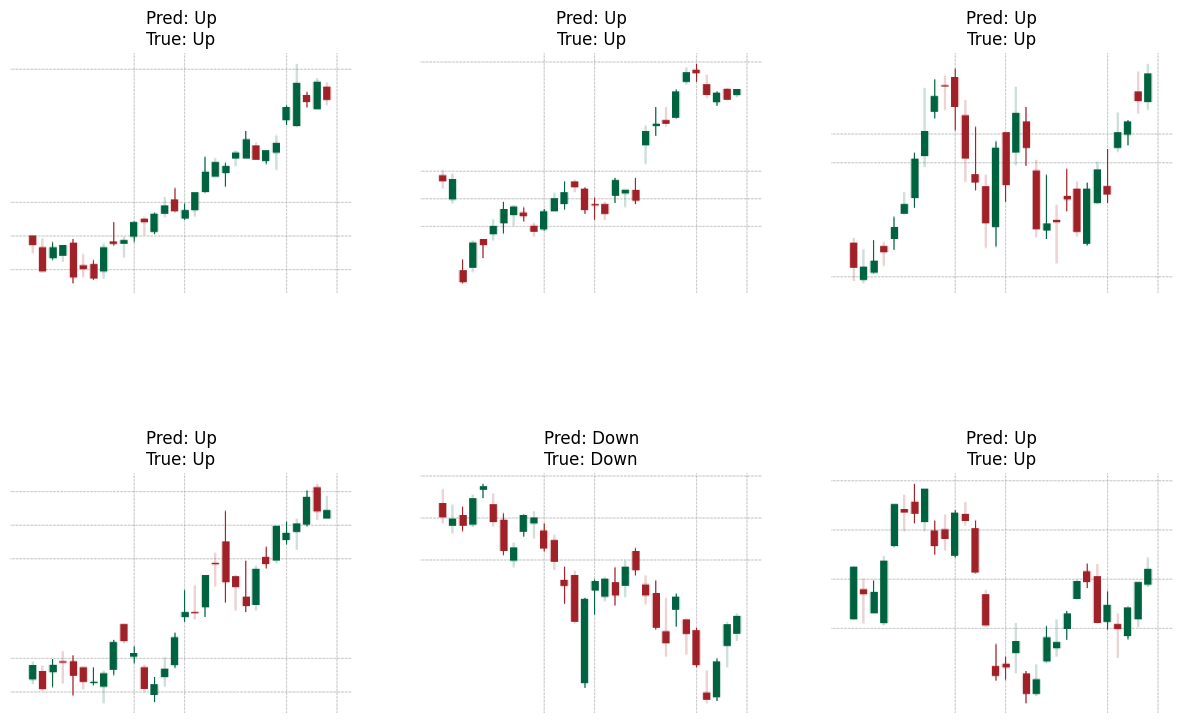

In [13]:
# Plot selected K-line (candlestick) charts with predictions and ground truth
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    ax[i // 3, i % 3].imshow(X_test[i]["image"])
    ax[i // 3, i % 3].set_title(f'Pred: {"Up" if y_pred_labels[i] == 1 else "Down"}\nTrue: {"Up" if y_test[i] == 1 else "Down"}')
    ax[i // 3, i % 3].axis("off")
plt.show()